In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import intake,yaml
import intake_esm
from scipy import special
import keras
from keras.models import Model
from keras.layers import Dense, Input

In [2]:
def latest_version(cat):
    """
    input
    cat: esmdatastore
    output
    esmdatastore with latest DRS versions
    """
    latest_cat = cat.df.sort_values(by=['version','path']).drop_duplicates(['temporal_subset','source_id','table_id',
                                               'institution_id','variable_id','member_id',
                                               'grid_label','experiment_id'],keep='last')
    return latest_cat

In [3]:
def chunk_time(ds):
    if 'time' in ds.dims:
        ds = ds.chunk({'time':1})
    return ds

In [4]:
# Necessary for creating a common time axis for all models
# We want to create a common time axis so there will be no gaps when plotting the results 

def fix_time(ds):
    """ force calendar to noleap"""
    import xarray as xr
    
    if "time" not in ds.dims:
        return ds
    
    if ("calendar" not in ds["time"].attrs): 
        ds["time"].attrs.update({"calendar": "noleap"})
        
    if ds["time"].attrs["calendar"] not in ["noleap", "NOLEAP", "365_day"]:
        ds["time"].attrs.update({"calendar": "noleap"})
        
    ds = xr.decode_cf(ds)
    return ds

In [5]:
def pp_enso(ds):
    ds = ds.copy()   #the wrapper function makes a copy of the ds and works from this
    #ds = rename_cmip6(ds)
    ds = fix_time(ds)
    #ds = fix_units(ds)
    #ds = correct_units(ds)
    return ds

In [6]:
#col_url = "https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.json" 
col_url = "https://raw.githubusercontent.com/aradhakrishnanGFDL/gfdl-aws-analysis/master/esm-collection-spec-examples/esgf-world.json"
col = intake.open_esm_datastore(col_url)
esmcol_data = col.esmcol_data

In [7]:
model_name = 'CNRM-CM6-1'

In [8]:
#mlotst, tos,uo,vo

In [9]:
#tos_ sea surface temperature
#area cello
#ofx ocean fixed
#omon  ocean monthly average 

In [10]:

query_Omon_tos = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 table_id=['Omon'],
                 member_id=["r1i1p1f1","r1i1p1f2"],
                 source_id=model_name,
                 grid_label=['gn'],
                 variable_id=["tos"])
query_Ofx = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 table_id=['Ofx'],
               member_id=["r1i1p1f1","r1i1p1f2"],
                 source_id=model_name,
                 grid_label=['gn'],
                 variable_id=["areacello"])

In [11]:
cat_Omon_tos = col.search(**query_Omon_tos)
cat_Omon_tos_lat = latest_version(cat_Omon_tos)

cat_Omon_tos_latest = intake.open_esm_datastore(cat_Omon_tos_lat,esmcol_data=esmcol_data)

In [12]:
cat_Omon_tos_latest.df

,project,institution_id,source_id,experiment_id,frequency,modeling_realm,table_id,member_id,grid_label,variable_id,temporal_subset,version,path
0,CMIP6,CNRM-CERFACS,CNRM-CM6-1,1pctCO2,mon,ocean,Omon,r1i1p1f2,gn,tos,185001-199912,v20180626,s3://esgf-world/CMIP6/CMIP/CNRM-CERFACS/CNRM-C...
1,CMIP6,CNRM-CERFACS,CNRM-CM6-1,abrupt-4xCO2,mon,ocean,Omon,r1i1p1f2,gn,tos,185001-199912,v20180705,s3://esgf-world/CMIP6/CMIP/CNRM-CERFACS/CNRM-C...
2,CMIP6,CNRM-CERFACS,CNRM-CM6-1,historical,mon,ocean,Omon,r1i1p1f2,gn,tos,185001-201412,v20180917,s3://esgf-world/CMIP6/CMIP/CNRM-CERFACS/CNRM-C...


In [13]:
cat_Ofx = col.search(**query_Ofx)
cat_Ofx_lat = latest_version(cat_Ofx)

cat_Ofx_latest = intake.open_esm_datastore(cat_Ofx_lat,esmcol_data=esmcol_data)

In [14]:
cat_Ofx_latest.df

,project,institution_id,source_id,experiment_id,frequency,modeling_realm,table_id,member_id,grid_label,variable_id,temporal_subset,version,path
0,CMIP6,CNRM-CERFACS,CNRM-CM6-1,1pctCO2,NaN,NaN,Ofx,r1i1p1f2,gn,areacello,NaN,v20180626,s3://esgf-world/CMIP6/CMIP/CNRM-CERFACS/CNRM-C...
1,CMIP6,CNRM-CERFACS,CNRM-CM6-1,abrupt-4xCO2,NaN,NaN,Ofx,r1i1p1f2,gn,areacello,NaN,v20180705,s3://esgf-world/CMIP6/CMIP/CNRM-CERFACS/CNRM-C...
2,CMIP6,CNRM-CERFACS,CNRM-CM6-1,historical,NaN,NaN,Ofx,r1i1p1f2,gn,areacello,NaN,v20180917,s3://esgf-world/CMIP6/CMIP/CNRM-CERFACS/CNRM-C...


In [15]:
dict_Omon_tos = cat_Omon_tos_latest.to_dataset_dict(storage_options=dict(anon=True), cdf_kwargs={'decode_times': True,'chunks': {'time': 1}}, preprocess = pp_enso)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.table_id'


In [16]:
dict_Ofx = cat_Ofx_latest.to_dataset_dict(storage_options=dict(anon=True),cdf_kwargs={'decode_times': True,'chunks': {}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.table_id'


In [17]:
dict_Omon_tos.keys()

dict_keys(['CMIP6.CNRM-CERFACS.CNRM-CM6-1.historical.Omon', 'CMIP6.CNRM-CERFACS.CNRM-CM6-1.abrupt-4xCO2.Omon', 'CMIP6.CNRM-CERFACS.CNRM-CM6-1.1pctCO2.Omon'])

In [18]:
dict_Ofx.keys()

dict_keys(['CMIP6.CNRM-CERFACS.CNRM-CM6-1.abrupt-4xCO2.Ofx', 'CMIP6.CNRM-CERFACS.CNRM-CM6-1.historical.Ofx', 'CMIP6.CNRM-CERFACS.CNRM-CM6-1.1pctCO2.Ofx'])

In [19]:
ds_Ofx = dict_Ofx['CMIP6.CNRM-CERFACS.CNRM-CM6-1.historical.Ofx'] #xarray dataset object to access Ofx areacello dataset used to calculate the weighted average

CALCULATING the summation of areacello

In [20]:
def distance_on_unit_sphere(lat1, long1, lat2, long2):

    # Convert latitude and longitude to
    # spherical coordinates in radians.
    degrees_to_radians = np.pi / 180.0

    # phi = 90 - latitude
    phi1 = (90.0 - lat1) * degrees_to_radians
    phi2 = (90.0 - lat2) * degrees_to_radians

    # theta = longitude
    theta1 = long1 * degrees_to_radians
    theta2 = long2 * degrees_to_radians
    # Compute spherical distance from spherical coordinates.
    # For two locations in spherical coordinates
    # (1, theta, phi) and (1, theta, phi)
    # cosine( arc length ) =
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
    cos = np.sin(phi1) * np.sin(phi2) * np.cos(theta1 - theta2) + np.cos(phi1) * np.cos(
        phi2
    )
    arc = np.arccos(cos)
    # Remember to multiply arc by the radius of the earth
    # in your favorite set of units to get length.
    return arc

In [21]:
def find_closest_grid_point(lon, lat, gridlon, gridlat):
    """find integer indices of closest grid point in grid of coordinates
    gridlon, gridlat for a given geographical lon/lat.
    PARAMETERS:
    -----------
        lon (float): longitude of point to find
        lat (float): latitude of point to find
        gridlon (numpy.ndarray): grid longitudes
        gridlat (numpy.ndarray): grid latitudes
    RETURNS:
    --------
    iclose, jclose: integer
        grid indices for geographical point of interest
    """

    if isinstance(gridlon, xr.core.dataarray.DataArray):
        gridlon = gridlon.values
    if isinstance(gridlat, xr.core.dataarray.DataArray):
        gridlat = gridlat.values
    dist = distance_on_unit_sphere(lat, lon, gridlat, gridlon)
    jclose, iclose = np.unravel_index(dist.argmin(), gridlon.shape)
    return iclose, jclose


In [22]:
ds_Ofx

<xarray.Dataset>
Dimensions:     (member_id: 1, nvertex: 4, x: 362, y: 294)
Coordinates:
    lat         (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon         (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * member_id   (member_id) <U8 'r1i1p1f2'
Dimensions without coordinates: nvertex, x, y
Data variables:
    bounds_lon  (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    bounds_lat  (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    areacello   (member_id, y, x) float32 dask.array<chunksize=(1, 294, 362), meta=np.ndarray>
Attributes: (12/54)
    name:                    /scratch/work/voldoire/outputs/CMIP6/DECK/CNRM-C...
    Conventions:             CF-1.7 CMIP-6.2
    creation_date:           2018-07-01T13:30:14Z
    tracking_id:             hdl:21.14100/2bdad953-add4-4787-a5e2-844a48837ee7
    description:             CMIP6 historical
    title:                   CNRM-CM6-1 model output prepared for CMIP6 / CMI...
    ...                      ...
    dr2xml_md5sum:           d6225e658d7de0912fca2a4293dbe2a7
    xios_commit:             1442-shuffle
    nemo_gelato_commit:      49095b3accd5d4c_6524fe19b00467a
    arpege_minor_version:    6.3.2
    intake_esm_varname:      ['areacello']
    intake_esm_dataset_key:  CMIP6.CNRM-CERFACS.CNRM-CM6-1.historical.Ofx

In [23]:
i,j= find_closest_grid_point(-157, -5, ds_Ofx.lon, ds_Ofx.lat)#for southwest
i,j

(130, 133)

In [24]:
k,l = find_closest_grid_point(-90, 5, ds_Ofx.lon, ds_Ofx.lat)#for northwest
k,l

(197, 163)

In [25]:
ds_Ofx.dims

Frozen(SortedKeysDict({'y': 294, 'x': 362, 'nvertex': 4, 'member_id': 1}))

In [26]:
#TODO INSERT CELL SELECT region of interest in areacello
areacello_nino3 = ds_Ofx.areacello.sel(y = slice(j,l), x = slice(i,k))


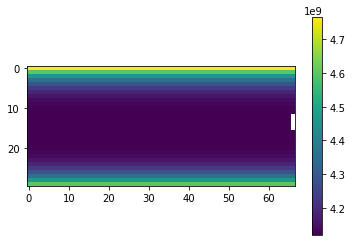

In [27]:
plt.imshow(areacello_nino3[0])
plt.colorbar()

In [28]:
#TODO 
#CALCULATE total_areacello, summation across lat,lon (in our dataset y,x respectively)

total_areacello = areacello_nino3.sum(dim=('x', 'y'))


In [39]:
1999-1850


149

In [44]:
ds_hist.info()

xarray.Dataset {
dimensions:
	axis_nbounds = 2 ;
	member_id = 1 ;
	nvertex = 4 ;
	time = 1980 ;
	x = 362 ;
	y = 294 ;

variables:
	float64 lat(y, x) ;
		lat:standard_name = latitude ;
		lat:long_name = Latitude ;
		lat:units = degrees_north ;
		lat:bounds = bounds_lat ;
	float64 lon(y, x) ;
		lon:standard_name = longitude ;
		lon:long_name = Longitude ;
		lon:units = degrees_east ;
		lon:bounds = bounds_lon ;
	float64 bounds_lon(y, x, nvertex) ;
	float64 bounds_lat(y, x, nvertex) ;
	datetime64[ns] time(time) ;
		time:axis = T ;
		time:standard_name = time ;
		time:long_name = Time axis ;
		time:time_origin = 1850-01-01 00:00:00 ;
		time:bounds = time_bounds ;
		time:calendar = noleap ;
	datetime64[ns] time_bounds(time, axis_nbounds) ;
	float32 tos(member_id, time, y, x) ;
		tos:standard_name = sea_surface_temperature ;
		tos:long_name = Sea Surface Temperature ;
		tos:units = degC ;
		tos:online_operation = average ;
		tos:cell_methods = area: mean where sea time: mean ;
		tos:interval

NINO3 INDEX CALCULATION 

REGION 

(5S-5N , 150W-90W) 

SELECT tos and areacello for the region of interest

## Historical

In [40]:
ds_hist = dict_Omon_tos["CMIP6.CNRM-CERFACS.CNRM-CM6-1.historical.Omon"]


In [41]:
ds_hist.coords

Coordinates:
    lat        (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon        (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * member_id  (member_id) <U8 'r1i1p1f2'

In [42]:
tm_his_st, tm_his_nd = "1980", "2011"


In [43]:
ds_hist.time.to_dataframe()

,time
time,
1850-01-16 12:00:00,1850-01-16 12:00:00
1850-02-15 00:00:00,1850-02-15 00:00:00
1850-03-16 12:00:00,1850-03-16 12:00:00
1850-04-16 00:00:00,1850-04-16 00:00:00
1850-05-16 12:00:00,1850-05-16 12:00:00
...,...
2014-08-16 12:00:00,2014-08-16 12:00:00
2014-09-16 00:00:00,2014-09-16 00:00:00
2014-10-16 12:00:00,2014-10-16 12:00:00


In [33]:
#ds_hist.time.to_dataframe()

In [48]:
tos_his = ds_hist.tos.sel(time = slice(tm_his_st, tm_his_nd))


In [59]:
#TODO INSERT CORRECT CODE TO SELECT SPECIFIED REGION (lat range and lon range) in TOS 
#tos = ds.tos......
tos_his = ds_hist.tos.sel(y = slice(j,l), x = slice(i,k), time = slice(tm_his_st, tm_his_nd))
tos_his

<xarray.DataArray 'tos' (member_id: 1, time: 384, y: 30, x: 67)>
dask.array<getitem, shape=(1, 384, 30, 67), dtype=float32, chunksize=(1, 1, 30, 67), chunktype=numpy.ndarray>
Coordinates:
    lat        (y, x) float64 dask.array<chunksize=(30, 67), meta=np.ndarray>
    lon        (y, x) float64 dask.array<chunksize=(30, 67), meta=np.ndarray>
  * time       (time) datetime64[ns] 1980-01-16T12:00:00 ... 2011-12-16T12:00:00
  * member_id  (member_id) <U8 'r1i1p1f2'
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_surface_temperature
    long_name:           Sea Surface Temperature
    units:               degC
    online_operation:    average
    cell_methods:        area: mean where sea time: mean
    interval_operation:  1800 s
    interval_write:      1 month
    description:         This may differ from "surface temperature" in region...
    history:             none
    cell_measures:       area: areacello

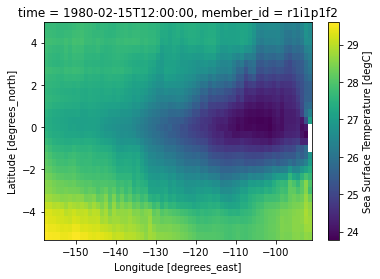

In [60]:
tos_his.isel(time=1).plot(x = "lon",y = "lat")


CALCULATE SEA SURFACE TEMPERATURE WEIGHTED AVERAGE

In [61]:
tos_mean_nino3_his = (tos_his * areacello_nino3).sum(dim=('x', 'y')) / total_areacello
#nino3_index.plot()

In [62]:
tos_mean_nino3_his = tos_mean_nino3_his.compute()
tos_mean_nino3_his

<xarray.DataArray (member_id: 1, time: 384)>
array([[27.147537, 26.883842, 27.10472 , 28.387712, 28.010752, 26.236176,
        25.336542, 24.864368, 24.55669 , 24.465254, 25.078434, 25.993406,
        25.485064, 24.971203, 25.382637, 25.586008, 25.02103 , 23.750347,
        23.284716, 22.916157, 23.60089 , 24.600231, 24.902342, 25.483173,
        26.465818, 26.61591 , 26.933756, 27.164707, 26.020933, 24.45756 ,
        23.648941, 23.137405, 22.387884, 22.118269, 22.204638, 22.458002,
        22.398228, 22.927717, 24.840467, 25.453903, 24.716127, 23.98471 ,
        23.073809, 22.83541 , 23.143833, 23.634686, 24.108826, 24.773123,
        25.236923, 25.173887, 26.049486, 25.79834 , 25.712473, 25.248257,
        24.981356, 24.758873, 24.66728 , 25.143969, 25.593931, 26.011248,
        26.526108, 25.829027, 26.303783, 27.446089, 27.07508 , 25.86154 ,
        25.169823, 24.613424, 24.248941, 24.557753, 25.210297, 25.633326,
        26.228947, 26.500225, 26.975931, 27.485317, 27.928026, 25.91041 ,
        25.479294, 25.258013, 25.216541, 25.197182, 25.313416, 25.93406 ,
        26.354809, 26.366556, 26.895044, 27.363983, 27.913866, 26.499914,
        25.214539, 24.892683, 24.633091, 25.008373, 25.569904, 25.872618,
        26.542952, 26.412462, 27.346731, 28.189997, 26.41754 , 25.150099,
        23.81466 , 23.100761, 22.388584, 22.58783 , 23.154886, 23.683884,
        24.40962 , 25.321426, 26.349323, 26.747345, 26.482405, 25.423447,
        24.792522, 24.047878, 24.354137, 25.42206 , 25.695772, 26.439909,
...
        24.170301, 23.539036, 23.733418, 23.994822, 24.381348, 24.969908,
        25.677666, 26.525644, 26.555662, 27.817122, 27.612427, 26.199928,
        25.687948, 25.08133 , 25.286116, 25.46453 , 25.756296, 26.521406,
        26.370039, 26.163738, 26.112577, 26.599726, 25.746714, 23.374155,
        22.55362 , 22.005377, 21.947945, 22.45624 , 22.793934, 22.865856,
        23.280632, 24.020813, 25.036098, 25.405699, 24.742924, 24.153563,
        24.020327, 23.731415, 23.778969, 24.32318 , 24.655062, 24.979849,
        25.305708, 25.174873, 26.35548 , 27.024567, 27.475996, 26.771633,
        26.349869, 25.512644, 25.51624 , 25.533745, 25.808603, 26.690786,
        27.312607, 28.071962, 28.434624, 28.528677, 29.054613, 27.182482,
        25.554893, 24.462275, 23.980064, 23.883333, 25.282043, 25.556597,
        26.285833, 25.73375 , 26.164871, 26.989475, 26.579317, 25.629444,
        24.393772, 23.525478, 23.34639 , 23.830698, 24.049318, 24.611002,
        25.713453, 25.52526 , 27.38268 , 27.613243, 26.802164, 25.775595,
        25.022114, 24.983656, 24.685305, 25.283682, 25.473404, 26.248621,
        26.605919, 27.26421 , 28.313824, 28.74986 , 28.188793, 26.798853,
        25.173176, 24.553204, 24.002821, 23.82405 , 23.833427, 24.20151 ,
        24.639761, 24.19706 , 24.316496, 25.354088, 26.13455 , 25.21024 ,
        25.094532, 24.5814  , 24.994581, 25.441095, 26.263336, 26.802412]],
      dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-16T12:00:00 ... 2011-12-16T12:00:00
  * member_id  (member_id) <U8 'r1i1p1f2'

In [63]:
tos_mean_nino3_his.size #1980 values, 1 value per month , 12 per year for 165 years

384

In [64]:
tos_mean_nino3_his.isel(time=0).compute()

<xarray.DataArray (member_id: 1)>
array([27.147537], dtype=float32)
Coordinates:
    time       datetime64[ns] 1980-01-16T12:00:00
  * member_id  (member_id) <U8 'r1i1p1f2'

In [47]:
#datetimeindex = tos_mean_nino3_his.indexes['time'].to_datetimeindex()
#tos_mean_nino3_his['time'] = datetimeindex


In [69]:
%pwd

'/home/jovyan/DNN4Cli/nino3SST_calc'

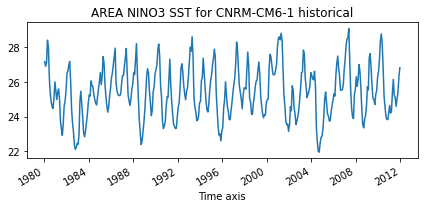

In [67]:
tos_mean_nino3_his.sel(time=slice(tm_his_st, tm_his_nd)).plot(aspect=2, size=3)
plt.title(f"AREA NINO3 SST for {model_name} historical")
plt.tight_layout()
plt.draw()
plt.savefig(f"{model_name}_SST_Hist_{tm_his_st}_{tm_his_nd}.png")

ADDITIONAL EXPLORATION

CLIMATOLOGY (average all Jans, Febs, etc) CALC EXAMPLES (YEARS NEED A TWEAK, calculate for 20 year chunks or as needed)

In [72]:
tos_nino3_climatology = tos_mean_nino3_his.groupby('time.month').mean(dim='time')


In [73]:
tos_nino3_climatology = tos_nino3_climatology.compute()

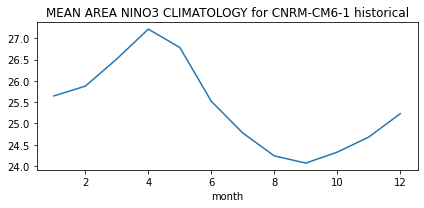

In [74]:
#tos_nino3_climatology.isel(month=0).plot()
tos_nino3_climatology.plot(aspect=2, size=3)
plt.title(f"MEAN AREA NINO3 CLIMATOLOGY for {model_name} historical")
plt.tight_layout()
plt.draw()
plt.savefig(f"{model_name}_Clima_Hist_{tm_his_st}_{tm_his_nd}.png")

monthly anomaly of SST (or TOS here) over the Nino3 region

we subtract the monthly climatology values calculated above from the TOS value values and then do
a spatial average across the region of interest

In [75]:
#tos_sel = tos_his.sel(time=slice(tm_his_st, tm_his_nd))
index_nino3 = (tos_his.groupby('time.month')-tos_nino3_climatology).mean(dim=['x','y'])

In [76]:
index_nino3 = index_nino3.compute()

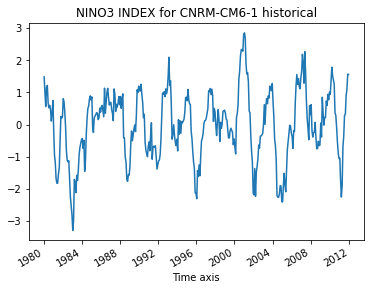

In [77]:
#datetimeindex = index_nino3.indexes['time'].to_datetimeindex()
#index_nino3['time'] = datetimeindex
index_nino3.plot()
plt.title(f"NINO3 INDEX for {model_name} historical")
plt.savefig(f"{model_name}_Nino3Idx_Hist_{tm_his_st}_{tm_his_nd}.png")

In [59]:
1998 -31


1967

## 1%CO2

In [57]:
ds_1pct = dict_Omon_tos["CMIP6.CNRM-CERFACS.CNRM-CM6-1.1pctCO2.Omon"]

In [58]:
ds_1pct.time.to_dataframe()

,time
time,
1850-01-16 12:00:00,1850-01-16 12:00:00
1850-02-15 00:00:00,1850-02-15 00:00:00
1850-03-16 12:00:00,1850-03-16 12:00:00
1850-04-16 00:00:00,1850-04-16 00:00:00
1850-05-16 12:00:00,1850-05-16 12:00:00
...,...
1999-08-16 12:00:00,1999-08-16 12:00:00
1999-09-16 00:00:00,1999-09-16 00:00:00
1999-10-16 12:00:00,1999-10-16 12:00:00


In [60]:
tm_1pct_st, tm_1pct_nd = "1967", "1998"



In [20]:
#tos_1pct = ds_1pct.tos#.sel(time = slice("1980", "2011"))

In [61]:
#TODO INSERT CORRECT CODE TO SELECT SPECIFIED REGION (lat range and lon range) in TOS 

tos_1pct = ds_1pct.tos.sel(y = slice(j,l), x = slice(i,k), time = slice(tm_1pct_st, tm_1pct_nd))
tos_1pct

<xarray.DataArray 'tos' (member_id: 1, time: 384, y: 30, x: 67)>
dask.array<getitem, shape=(1, 384, 30, 67), dtype=float32, chunksize=(1, 1, 30, 67), chunktype=numpy.ndarray>
Coordinates:
    lat        (y, x) float64 dask.array<chunksize=(30, 67), meta=np.ndarray>
    lon        (y, x) float64 dask.array<chunksize=(30, 67), meta=np.ndarray>
  * time       (time) datetime64[ns] 1967-01-16T12:00:00 ... 1998-12-16T12:00:00
  * member_id  (member_id) <U8 'r1i1p1f2'
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_surface_temperature
    long_name:           Sea Surface Temperature
    units:               degC
    online_operation:    average
    cell_methods:        area: mean where sea time: mean
    interval_operation:  1800 s
    interval_write:      1 month
    description:         This may differ from "surface temperature" in region...
    history:             none
    cell_measures:       area: areacello

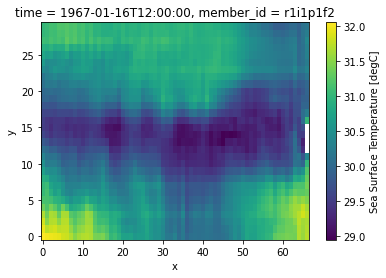

In [62]:
tos_1pct.isel(time=0).plot()

CALCULATE SEA SURFACE TEMPERATURE WEIGHTED AVERAGE

In [63]:
tos_mean_nino3_1pct = (tos_1pct * areacello_nino3).sum(dim=('x', 'y')) / total_areacello
#nino3_index.plot()

In [64]:
tos_mean_nino3_1pct = tos_mean_nino3_1pct.compute()

In [65]:
tos_mean_nino3_1pct.size

384

In [66]:
tos_mean_nino3_1pct.isel(time=0).compute()

<xarray.DataArray (member_id: 1)>
array([30.287127], dtype=float32)
Coordinates:
    time       datetime64[ns] 1967-01-16T12:00:00
  * member_id  (member_id) <U8 'r1i1p1f2'

In [40]:
#datetimeindex_1pct = tos_mean_nino3_1pct.indexes['time'].to_datetimeindex()

In [41]:
#tos_mean_nino3_1pct['time'] = datetimeindex_1pct

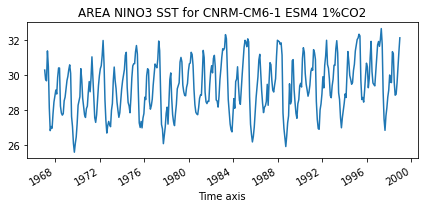

In [67]:
tos_mean_nino3_1pct.plot(aspect=2, size=3)
plt.title(f"AREA NINO3 SST for {model_name} ESM4 1%CO2")
plt.tight_layout()
plt.draw()
plt.savefig(f"{model_name}_1pctCo2_SST_{tm_1pct_st}_{tm_1pct_nd}.png")

In [68]:
tos_nino3_climatology_1pct = tos_mean_nino3_1pct.groupby('time.month').mean(dim='time')


In [69]:
tos_nino3_climatology_1pct = tos_nino3_climatology_1pct.compute()

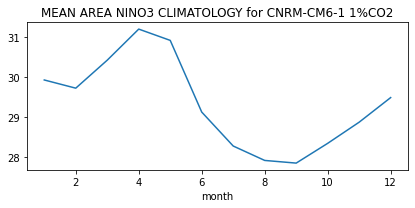

In [70]:
#tos_nino3_climatology_1pct.isel(month=0).plot()
tos_nino3_climatology_1pct.plot(aspect=2, size=3)
plt.title(f"MEAN AREA NINO3 CLIMATOLOGY for {model_name} 1%CO2")
plt.tight_layout()
plt.draw()
plt.savefig(f"{model_name}_1pctCO2_Clima_{tm_1pct_st}_{tm_1pct_nd}.png")

monthly anomaly of SST (or TOS here) over the Nino3 region

we subtract the monthly climatology values calculated above from the TOS value values and then do
a spatial average across the region of interest

In [71]:
#tos_sel = tos_1pct.sel(time=slice('0119','0150'))
index_nino3 = (tos_1pct.groupby('time.month')-tos_nino3_climatology_1pct).mean(dim=['x','y'])

In [72]:
index_nino3 = index_nino3.compute()

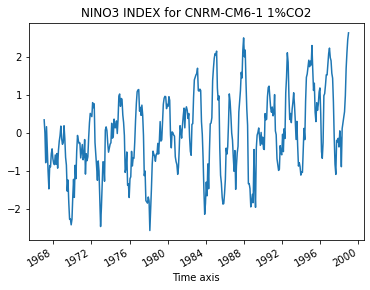

In [73]:
#datetimeindex = index_nino3.indexes['time'].to_datetimeindex()
#index_nino3['time'] = datetimeindex
index_nino3.plot()
plt.title(f"NINO3 INDEX for {model_name} 1%CO2")
plt.savefig(f"{model_name}_1pctCO2_Nino3Idx_{tm_1pct_st}_{tm_1pct_nd}.png")

## Abrupt-4xCO2

In [75]:
ds_4x = dict_Omon_tos["CMIP6.CNRM-CERFACS.CNRM-CM6-1.abrupt-4xCO2.Omon"]

In [76]:
ds_4x.time.to_dataframe()

,time
time,
1850-01-16 12:00:00,1850-01-16 12:00:00
1850-02-15 00:00:00,1850-02-15 00:00:00
1850-03-16 12:00:00,1850-03-16 12:00:00
1850-04-16 00:00:00,1850-04-16 00:00:00
1850-05-16 12:00:00,1850-05-16 12:00:00
...,...
1999-08-16 12:00:00,1999-08-16 12:00:00
1999-09-16 00:00:00,1999-09-16 00:00:00
1999-10-16 12:00:00,1999-10-16 12:00:00


In [77]:
tm_4x_st,tm_4x_nd = "1967", "1998"

In [78]:
#TODO INSERT CORRECT CODE TO SELECT SPECIFIED REGION (lat range and lon range) in TOS 
#tos = ds.tos......
tos_4x = ds_4x.tos.sel(y = slice(j,l), x= slice(i,k), time = slice(tm_4x_st,tm_4x_nd) )
tos_4x

<xarray.DataArray 'tos' (member_id: 1, time: 384, y: 30, x: 67)>
dask.array<getitem, shape=(1, 384, 30, 67), dtype=float32, chunksize=(1, 1, 30, 67), chunktype=numpy.ndarray>
Coordinates:
    lat        (y, x) float64 dask.array<chunksize=(30, 67), meta=np.ndarray>
    lon        (y, x) float64 dask.array<chunksize=(30, 67), meta=np.ndarray>
  * time       (time) datetime64[ns] 1967-01-16T12:00:00 ... 1998-12-16T12:00:00
  * member_id  (member_id) <U8 'r1i1p1f2'
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_surface_temperature
    long_name:           Sea Surface Temperature
    units:               degC
    online_operation:    average
    cell_methods:        area: mean where sea time: mean
    interval_operation:  1800 s
    interval_write:      1 month
    description:         This may differ from "surface temperature" in region...
    history:             none
    cell_measures:       area: areacello

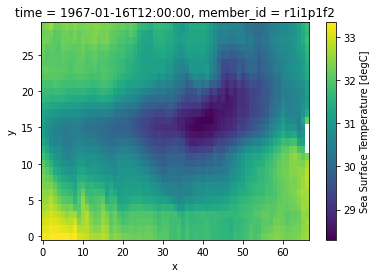

In [79]:
tos_4x.isel(time=0).plot()

CALCULATE SEA SURFACE TEMPERATURE WEIGHTED AVERAGE

In [80]:
tos_mean_nino3_4x = (tos_4x * areacello_nino3).sum(dim=('x', 'y')) / total_areacello
#nino3_index.plot()

In [81]:
tos_mean_nino3_4x = tos_mean_nino3_4x.compute()

In [82]:
tos_mean_nino3_4x.size #1980 values, 1 value per month , 12 per year for 165 years

384

In [83]:
tos_mean_nino3_4x.isel(time=0).compute()

<xarray.DataArray (member_id: 1)>
array([31.00425], dtype=float32)
Coordinates:
    time       datetime64[ns] 1967-01-16T12:00:00
  * member_id  (member_id) <U8 'r1i1p1f2'

In [ ]:
#datetimeindex_4x = tos_mean_nino3_4x.indexes['time'].to_datetimeindex()
#tos_mean_nino3_4x['time'] = datetimeindex_4x


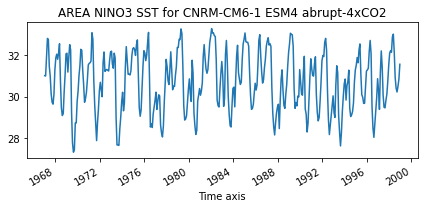

In [84]:
tos_mean_nino3_4x.plot(aspect=2, size=3)
plt.title(f"AREA NINO3 SST for {model_name} ESM4 abrupt-4xCO2")
plt.tight_layout()
plt.draw()
plt.savefig(f"{model_name}_4xCo2_SST_{tm_4x_st}_{tm_4x_nd}.png")

In [85]:
tos_nino3_climatology_4x = tos_mean_nino3_4x.groupby('time.month').mean(dim='time')


In [88]:
tos_nino3_climatology_4x = tos_nino3_climatology_4x.compute()

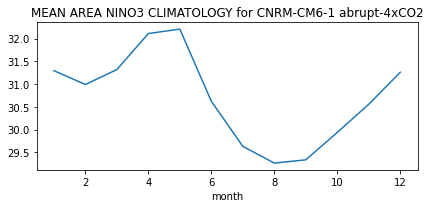

In [89]:
#tos_nino3_climatology_4x.isel(month=0).plot()
tos_nino3_climatology_4x.plot(aspect=2, size=3)
plt.title(f"MEAN AREA NINO3 CLIMATOLOGY for {model_name} abrupt-4xCO2")
plt.tight_layout()
plt.draw()
plt.savefig(f"{model_name}_4xCO2_Clima_{tm_1pct_st}_{tm_1pct_nd}.png")

monthly anomaly of SST (or TOS here) over the Nino3 region

we subtract the monthly climatology values calculated above from the TOS value values and then do
a spatial average across the region of interest

In [90]:
#tos_sel_4x = tos_4x.sel(time=slice('0119','0150'))
index_nino3_4x = (tos_4x.groupby('time.month')-tos_nino3_climatology_4x).mean(dim=['x','y'])

In [91]:
index_nino3_4x = index_nino3_4x.compute()

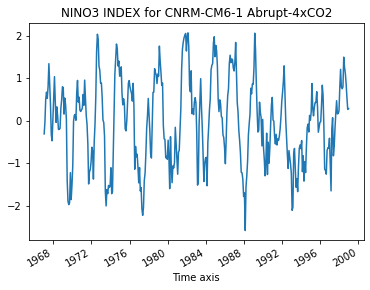

In [92]:
#datetimeindex = index_nino3.indexes['time'].to_datetimeindex()
#index_nino3['time'] = datetimeindex

index_nino3_4x.plot()
plt.title(f"NINO3 INDEX for {model_name} Abrupt-4xCO2")
plt.savefig(f"{model_name}_4xCO2_Nino3Idx_{tm_1pct_st}_{tm_1pct_nd}.png")